# Feature Engineering

This notebook covers the feature engineering process of this project

In this notebook, we:

1. define target variables
    1. Create a new feature that notes if a failure occurs in the future
    2. Expand feature to 4 columns so we can observe which specific component fails
2. Create features from telemetry dataf (some things we may want below:)
    1. Rolling windowed averages
        1. What windows should we use
    2. Time since last maintenance on a component (is this a lag feature?)
    3. 


### Arising Question
Can we have *too many* features?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
errors = pd.read_csv('data/PdM_errors.csv')
failures = pd.read_csv('data/PdM_failures.csv')
machines = pd.read_csv('data/PdM_machines.csv')
maint = pd.read_csv('data/PdM_maint.csv')
telemetry = pd.read_csv('data/PdM_telemetry.csv')
# Convert datetime columns to pandas datetime
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maint['datetime'] = pd.to_datetime(maint['datetime'])
errors['datetime'] = pd.to_datetime(errors['datetime'])


### Making target variables
Targets: `failure_next_24h	failure_comp4_next_24h	failure_comp1_next_24h	failure_comp2_next_24h	failure_comp3_next_24h`

Maybe omit the first one and just determine which component fails directly. 

RUNTIME: ~9 minutes. Quite long because lots of rows

In [3]:
# Merge telemetry with machines to get model types
telemetry_with_model = pd.merge(telemetry, machines, on='machineID')

# Define the prediction window
prediction_window = pd.Timedelta(hours=24)  # Set x hours here

# Initialize target columns
telemetry_with_model['failure_next_24h'] = 0
components = failures['failure'].unique()
for component in components:
    telemetry_with_model[f'failure_{component}_next_24h'] = 0

# Populate the target columns
for idx, row in telemetry_with_model.iterrows():
    machine_failures = failures[failures['machineID'] == row['machineID']]
    future_failures = machine_failures[(machine_failures['datetime'] > row['datetime']) & 
                                       (machine_failures['datetime'] <= row['datetime'] + prediction_window)]
    if not future_failures.empty:
        telemetry_with_model.at[idx, 'failure_next_24h'] = 1 # maybe omit this, more specific comp failure renders this column obsolete
        for component in components:
            if component in future_failures['failure'].values:
                telemetry_with_model.at[idx, f'failure_{component}_next_24h'] = 1

print(telemetry_with_model.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration   model  age  failure_next_24h  failure_comp4_next_24h  \
0  45.087686  model3   18                 0                       0   
1  43.413973  model3   18                 0                       0   
2  34.178847  model3   18                 0                       0   
3  41.122144  model3   18                 0                       0   
4  25.990511  model3   18                 0                       0   

   failure_comp1_next_24h  failure_comp2_next_24h  failure_comp3_next_24h  
0                       0                       0               

In [4]:
telemetry_with_model

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure_next_24h,failure_comp4_next_24h,failure_comp1_next_24h,failure_comp2_next_24h,failure_comp3_next_24h
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,0,0,0,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,0,0,0,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,0,0,0,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,0,0,0,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,model4,5,0,0,0,0,0
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,model4,5,0,0,0,0,0
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,model4,5,0,0,0,0,0
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,model4,5,0,0,0,0,0


In [5]:
telemetry_with_model[telemetry_with_model.failure_next_24h == 1].head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure_next_24h,failure_comp4_next_24h,failure_comp1_next_24h,failure_comp2_next_24h,failure_comp3_next_24h
72,2015-01-04 06:00:00,1,165.010140,448.468838,97.709630,48.238941,model3,18,1,1,0,0,0
73,2015-01-04 07:00:00,1,142.666469,433.279499,118.853452,54.848731,model3,18,1,1,0,0,0
74,2015-01-04 08:00:00,1,191.168936,479.615136,101.999663,52.882567,model3,18,1,1,0,0,0
75,2015-01-04 09:00:00,1,157.436263,438.091311,113.100915,53.695544,model3,18,1,1,0,0,0
76,2015-01-04 10:00:00,1,153.143558,440.162685,94.524894,57.411078,model3,18,1,1,0,0,0


### Other feature engineering
This is time series data. We can use lag features (for each row, include previous rows as our data to capture trends in our forecasting) and rolling means/averages.

In [6]:
errors

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [8]:
telemetry_with_model = pd.merge(telemetry, machines, on='machineID')

# Define the prediction window
prediction_window = pd.Timedelta(hours=24)

# Initialize target columns for each component
components = failures['failure'].unique()
for component in components:
    telemetry_with_model[f'failure_{component}_next_24h'] = 0

# Populate the target columns
for idx, row in telemetry_with_model.iterrows():
    machine_failures = failures[failures['machineID'] == row['machineID']]
    future_failures = machine_failures[(machine_failures['datetime'] > row['datetime']) & 
                                       (machine_failures['datetime'] <= row['datetime'] + prediction_window)]
    for component in components:
        if component in future_failures['failure'].values:
            telemetry_with_model.at[idx, f'failure_{component}_next_24h'] = 1

# Create lag features
lags = [1, 2, 3]
for feature in ['volt', 'rotate', 'pressure', 'vibration']:
    for lag in lags:
        telemetry_with_model[f'{feature}_lag{lag}'] = telemetry_with_model.groupby('machineID')[feature].shift(lag)

# Create rolling statistics
window_sizes = [6, 12]
for feature in ['volt', 'rotate', 'pressure', 'vibration']:
    for window in window_sizes:
        telemetry_with_model[f'{feature}_roll_mean_{window}'] = telemetry_with_model.groupby('machineID')[feature].rolling(window=window).mean().reset_index(level=0, drop=True)

# Drop NaN values created by shifting
telemetry_with_model.dropna(inplace=True)

# Create windowed error count features for each error type
error_types = errors['errorID'].unique()
window_sizes = [6, 12]
for error_type in error_types:
    for window in window_sizes:
        telemetry_with_model[f'{error_type}_count_{window}h'] = 0

# Populate the error count features
for idx, row in telemetry_with_model.iterrows():
    machine_errors = errors[errors['machineID'] == row['machineID']]
    
    for error_type in error_types:
        for window in window_sizes:
            window_start = row['datetime'] - pd.Timedelta(hours=window)
            window_errors = machine_errors[(machine_errors['datetime'] > window_start) & (machine_errors['datetime'] <= row['datetime']) & (machine_errors['errorID'] == error_type)]
            telemetry_with_model.at[idx, f'{error_type}_count_{window}h'] = len(window_errors)
            
# Define features and target variables
features = [col for col in telemetry_with_model.columns if col not in ['datetime', 'machineID', 'model'] + [f'failure_{comp}_next_24h' for comp in components]]
targets = [f'failure_{comp}_next_24h' for comp in components]


### Dataset Imbalance

We can see that there is a big difference in dataset size. When initially running the model, a confusion matrix made it obvious that we were mostly labelling things the majority class (no failure), which can easily mislead us to a high accuracy. In reality, it would mislabel failures as a non-failure.

To address this, we can adjust weights or use data sampling methods like SMOTE.

In [9]:
dataset_size = len(telemetry_with_model[targets])
failure_counts = telemetry_with_model[targets].sum()
print(f'Data size: {dataset_size}\n')
print(f'Failures: \n{failure_counts}\n')
print(f'Non-failures: \n{dataset_size - failure_counts}')


Data size: 875000

Failures: 
failure_comp4_next_24h    4254
failure_comp1_next_24h    4460
failure_comp2_next_24h    6174
failure_comp3_next_24h    3091
dtype: int64

Non-failures: 
failure_comp4_next_24h    870746
failure_comp1_next_24h    870540
failure_comp2_next_24h    868826
failure_comp3_next_24h    871909
dtype: int64


In [10]:
# Split the data into training and testing sets
X = telemetry_with_model[features]
y = telemetry_with_model[targets]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from mlsmote import create_dataset, get_minority_instace, MLSMOTE
X_sub, y_sub = get_minority_instace(X, y) 

X_res, y_res = MLSMOTE(X_sub, y_sub, 500)

X_sm = pd.concat([X, X_res], axis=0)
y_sm = pd.concat([y, y_res], axis=0)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)


# Apply SMOTE to each target variable separately and concatenate the results
# X_train_resampled = []
# y_train_resampled = []

# for target in targets:
#     sm = SMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X_train, y_train[target])
#     X_train_resampled.append(X_res)
#     y_train_resampled.append(y_res)

# X_train_res = []
# y_train_res = pd.DataFrame()

# for target in targets:
#     smote = SMOTE(random_state=42)
#     X_res, y_res = smote.fit_resample(X_train, y_train[target])
#     X_train_res.append(X_res)
#     y_train_res[target] = y_res

# Ensure the resampled features match the shape
# X_train_res = pd.concat(X_train_res, axis=0)
# y_train_res = y_train_res.loc[X_train_res.index]

# Model Training & Evaluation

### Training

In [11]:
# Define and train the model
# model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
# model.fit(X_train, y_train)

# Define and train the XGBoost model with balanced class weights
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,n_estimators=500, learning_rate=0.15, colsample_bytree=0.3, max_depth=3)
model = MultiOutputClassifier(xgb_clf)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)

# Evaluate the model
for i, target in enumerate(targets):
    print(f'Classification Report for {target}:')
    print(classification_report(y_test[target], y_pred[:, i]))

# Example of overall evaluation
from sklearn.metrics import accuracy_score, hamming_loss

accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f'Overall Accuracy: {accuracy}')
print(f'Hamming Loss: {hamming}')

Classification Report for failure_comp4_next_24h:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    174822
         1.0       0.98      0.53      0.68       897

    accuracy                           1.00    175719
   macro avg       0.99      0.76      0.84    175719
weighted avg       1.00      1.00      1.00    175719

Classification Report for failure_comp1_next_24h:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    174802
         1.0       0.87      0.50      0.63       917

    accuracy                           1.00    175719
   macro avg       0.93      0.75      0.82    175719
weighted avg       1.00      1.00      1.00    175719

Classification Report for failure_comp2_next_24h:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    174429
         1.0       0.98      0.52      0.68      1290

    accuracy                    

### Evaluation

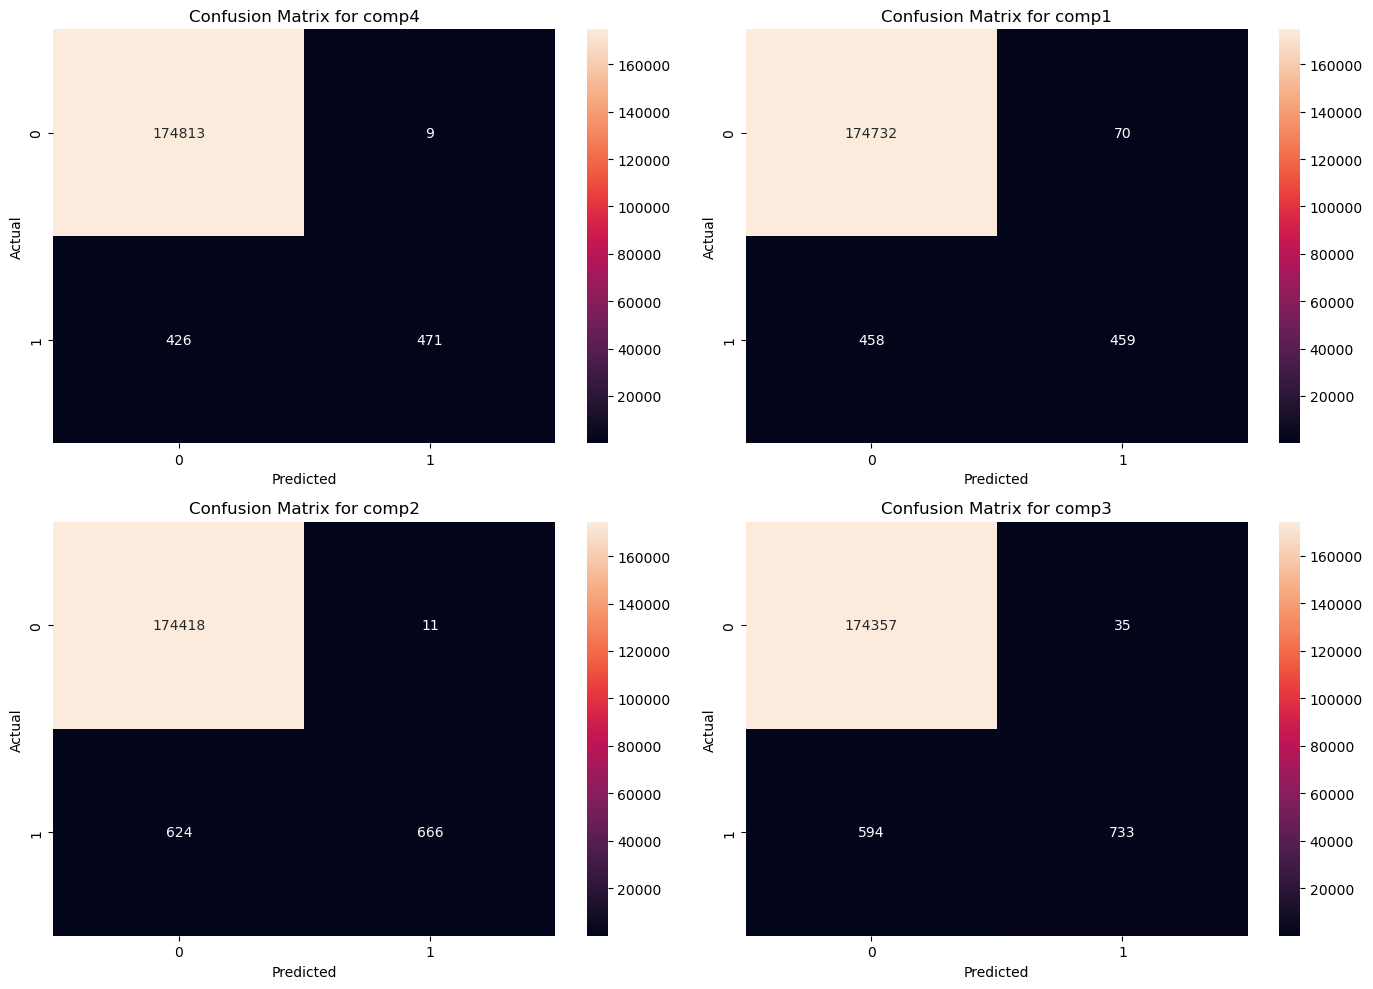

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for i, component in enumerate(components):
    cm = confusion_matrix(y_test[targets[i]], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {component}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


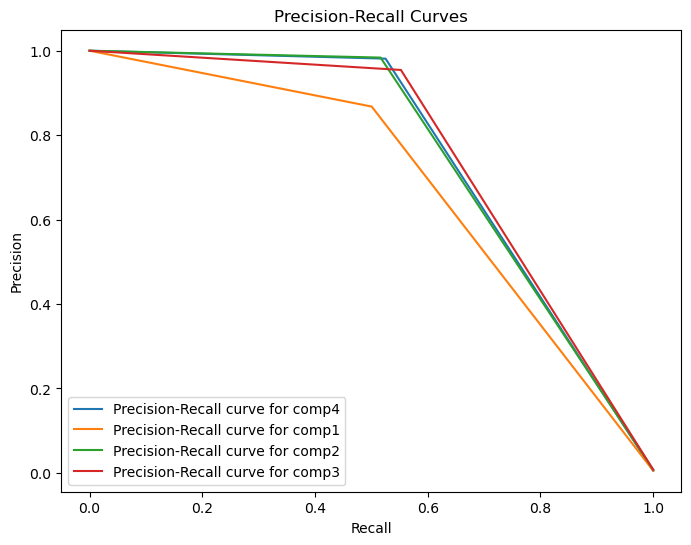

In [13]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i, component in enumerate(components):
    precision, recall, _ = precision_recall_curve(y_test[targets[i]], y_pred[:, i])
    plt.plot(recall, precision, label=f'Precision-Recall curve for {component}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()


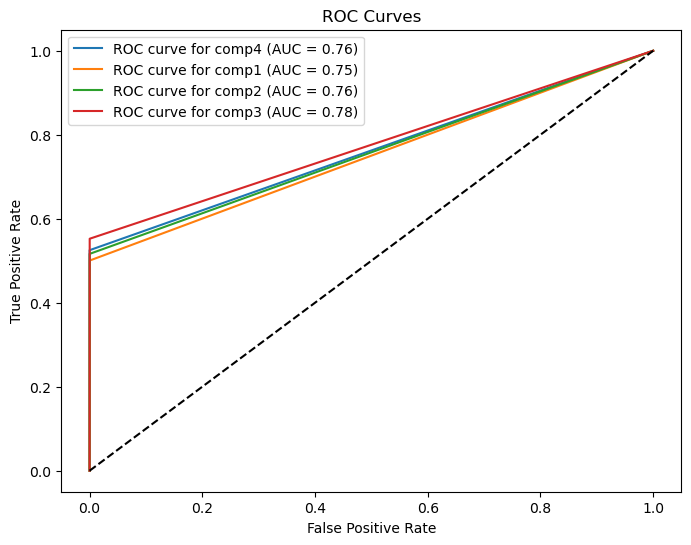

In [14]:
# ROC Curve
plt.figure(figsize=(8, 6))
for i, component in enumerate(components):
    fpr, tpr, _ = roc_curve(y_test[targets[i]], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {component} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()